In [ ]:
# Install required libraries
!pip install ultralytics opencv-python pandas scikit-learn matplotlib kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()

Saving k6.json to k6.json


{'k6.json': b'{"username":"geethikareddyindla","key":"debf8fac412d2dd1c5fbcd354412ce3e"}'}

In [ ]:
!mv k6.json kaggle.json


In [ ]:
import os

os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d hayriyigit/chicken-detection

Dataset URL: https://www.kaggle.com/datasets/hayriyigit/chicken-detection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/36.1M [00:00<?, ?B/s]
100% 36.1M/36.1M [00:00<00:00, 2.10GB/s]


In [ ]:
!unzip chicken-detection.zip

Archive:  chicken-detection.zip
  inflating: dataset/train/0055_png.rf.11961917e8380bcadb38d84949679f85.jpg  
  inflating: dataset/train/0057_png.rf.e1e47121411ed98d0928b9a22e0d2a63.jpg  
  inflating: dataset/train/0058_png.rf.14be1b4801c7b987dd47474d8fd2a9f5.jpg  
  inflating: dataset/train/0059_png.rf.a70daed88d742ac6eb9b3abd946898e8.jpg  
  inflating: dataset/train/0061_png.rf.e095e356554f4c998fb93e644a9007b8.jpg  
  inflating: dataset/train/0063_png.rf.c3ff475c1589984b0122751f53360dba.jpg  
  inflating: dataset/train/0065_png.rf.3f73fa71a30adc51159ff107eeec00bb.jpg  
  inflating: dataset/train/0066_png.rf.3a0d67be82abc40134fdf4dfa05f96f5.jpg  
  inflating: dataset/train/0068_png.rf.616814bfca6ef0e6992e79e449bd4d1f.jpg  
  inflating: dataset/train/0069_png.rf.17b1c58a1c6be5ae4134714e1e66a961.jpg  
  inflating: dataset/train/0070_png.rf.554febc0b9bc7fb9bcc703da4512a609.jpg  
  inflating: dataset/train/0073_png.rf.8a213c4cb33d88e7d338faa34154cb88.jpg  
  inflating: dataset/train/0074_

In [ ]:
pip install pycocotools


In [ ]:
import json
import os
from pathlib import Path
from PIL import Image

# Paths
coco_json = "dataset/train/_annotations.coco.json"
images_dir = "dataset/train"
labels_dir = "dataset/train/labels"

os.makedirs(labels_dir, exist_ok=True)

with open(coco_json) as f:
    coco = json.load(f)

# Map image id → filename
image_map = {img["id"]: img["file_name"] for img in coco["images"]}

# Prepare annotation mapping
annotations = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    annotations.setdefault(img_id, []).append(ann)

# Convert each image annotation
for img_id, anns in annotations.items():
    img_name = image_map[img_id]
    img_path = os.path.join(images_dir, img_name)

    if not os.path.exists(img_path):
        continue

    with Image.open(img_path) as img:
        w, h = img.size

    label_file = Path(labels_dir) / img_name.replace(".jpg", ".txt")

    with open(label_file, "w") as f:
        for ann in anns:
            x, y, bw, bh = ann["bbox"]
            x_center = (x + bw / 2) / w
            y_center = (y + bh / 2) / h
            bw /= w
            bh /= h

            class_id = 0  # single class: bird
            f.write(f"{class_id} {x_center} {y_center} {bw} {bh}\n")

print("COCO → YOLO conversion completed")


COCO → YOLO conversion completed


In [ ]:
os.makedirs("train/images", exist_ok=True)
os.makedirs("train/labels", exist_ok=True)

for file in os.listdir("dataset/train"):
    if file.endswith(".jpg"):
        os.rename(f"dataset/train/{file}", f"train/images/{file}")

for file in os.listdir("dataset/train/labels"):
    os.rename(f"dataset/train/labels/{file}", f"train/labels/{file}")


In [ ]:
import random, shutil

imgs = os.listdir("train/images")
random.shuffle(imgs)

val_count = int(0.2 * len(imgs))
val_imgs = imgs[:val_count]

os.makedirs("val/images", exist_ok=True)
os.makedirs("val/labels", exist_ok=True)

for img in val_imgs:
    shutil.move(f"train/images/{img}", f"val/images/{img}")
    shutil.move(
        f"train/labels/{img.replace('.jpg','.txt')}",
        f"val/labels/{img.replace('.jpg','.txt')}"
    )


In [ ]:
%%writefile data.yaml
path: .
train: train/images
val: val/images

nc: 1
names: ["bird"]


Writing data.yaml


In [ ]:
!cat data.yaml


path: .
train: train/images
val: val/images

nc: 1
names: ["bird"]


In [ ]:
!ls train
!ls val


images	labels
images	labels


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=8
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d45cfe3a120>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
#Test on Validation Images (Detection Accuracy)
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")


In [ ]:
model.predict(
    source="val/images",
    conf=0.4,
    save=True
)



image 1/75 /content/val/images/0058_png.rf.14be1b4801c7b987dd47474d8fd2a9f5.jpg: 640x640 3 birds, 171.7ms
image 2/75 /content/val/images/0063_png.rf.c3ff475c1589984b0122751f53360dba.jpg: 640x640 6 birds, 147.6ms
image 3/75 /content/val/images/0065_png.rf.3f73fa71a30adc51159ff107eeec00bb.jpg: 640x640 6 birds, 154.0ms
image 4/75 /content/val/images/0068_png.rf.616814bfca6ef0e6992e79e449bd4d1f.jpg: 640x640 7 birds, 157.8ms
image 5/75 /content/val/images/0069_png.rf.17b1c58a1c6be5ae4134714e1e66a961.jpg: 640x640 5 birds, 146.9ms
image 6/75 /content/val/images/0074_png.rf.6910d88e8600369dbb4a25c398bcb66f.jpg: 640x640 5 birds, 147.7ms
image 7/75 /content/val/images/0092_png.rf.7521272da7bfe0daf33cef563bef732b.jpg: 640x640 3 birds, 148.9ms
image 8/75 /content/val/images/0101_png.rf.8ead89aa99a64a95abf09470f95aec1b.jpg: 640x640 3 birds, 154.7ms
image 9/75 /content/val/images/0107_png.rf.82135cc56e7832fa2230ba66db88c614.jpg: 640x640 3 birds, 153.9ms
image 10/75 /content/val/images/0113_png.rf.7

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bird'}
 obb: None
 orig_img: array([[[109, 119, 137],
         [109, 119, 137],
         [106, 118, 136],
         ...,
         [ 74,  75,  73],
         [ 73,  74,  72],
         [ 72,  73,  71]],
 
        [[110, 120, 138],
         [109, 119, 137],
         [107, 119, 137],
         ...,
         [ 74,  75,  73],
         [ 73,  74,  72],
         [ 72,  73,  71]],
 
        [[110, 120, 138],
         [109, 119, 137],
         [107, 119, 137],
         ...,
         [ 74,  75,  73],
         [ 73,  74,  72],
         [ 72,  73,  71]],
 
        ...,
 
        [[121, 135, 158],
         [120, 134, 157],
         [ 97, 108, 130],
         ...,
         [147, 163, 179],
         [149, 162, 176],
         [158, 171, 185]],
 
        [[102, 116, 139],
         [ 77,  91, 114],
         [ 43,  54,  76],
         ...,
         [153, 169, 

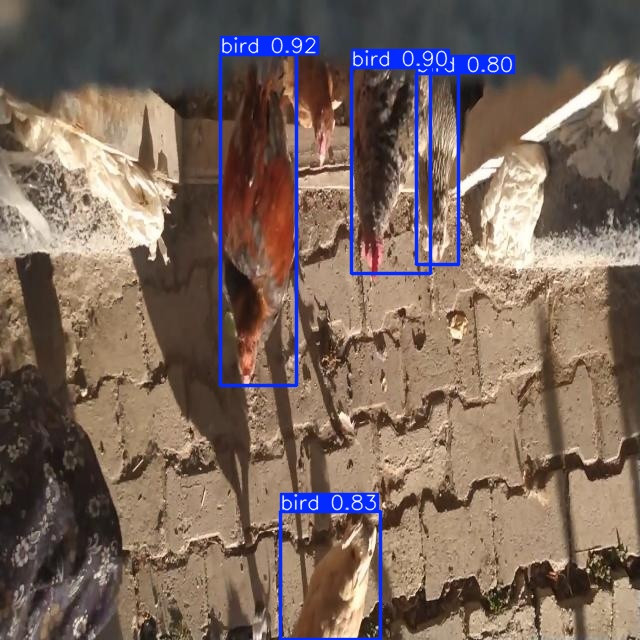

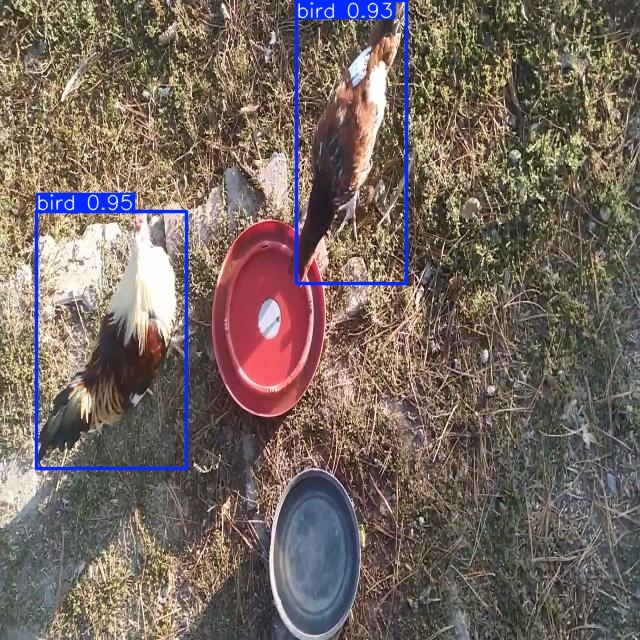

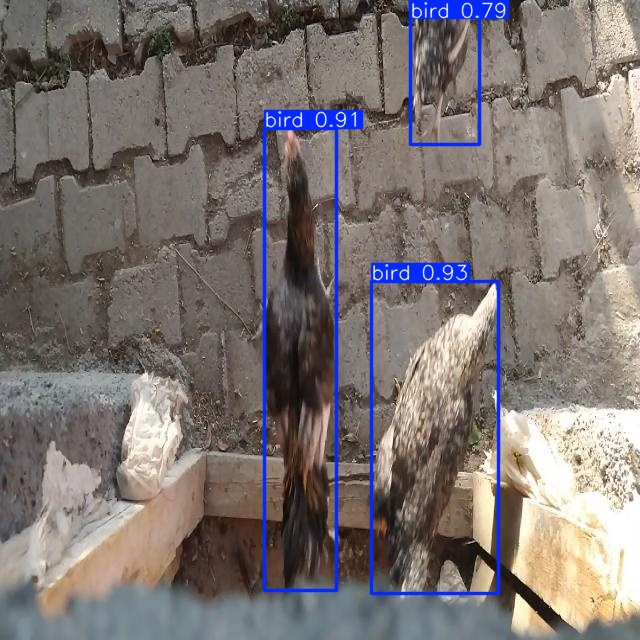

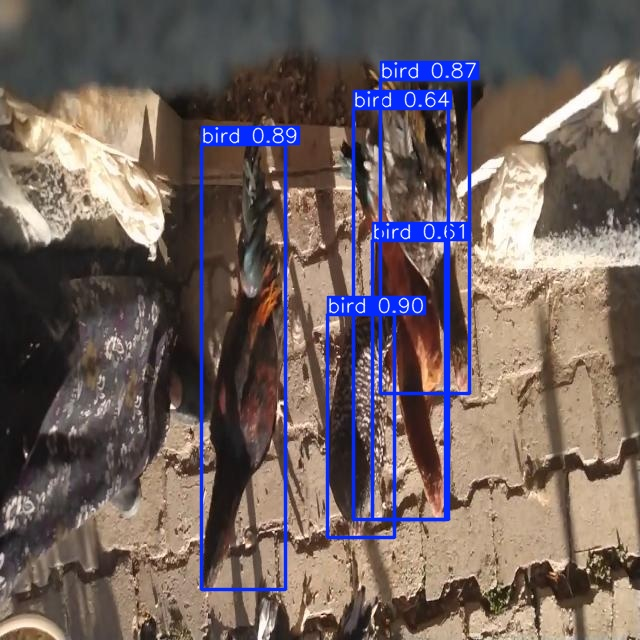

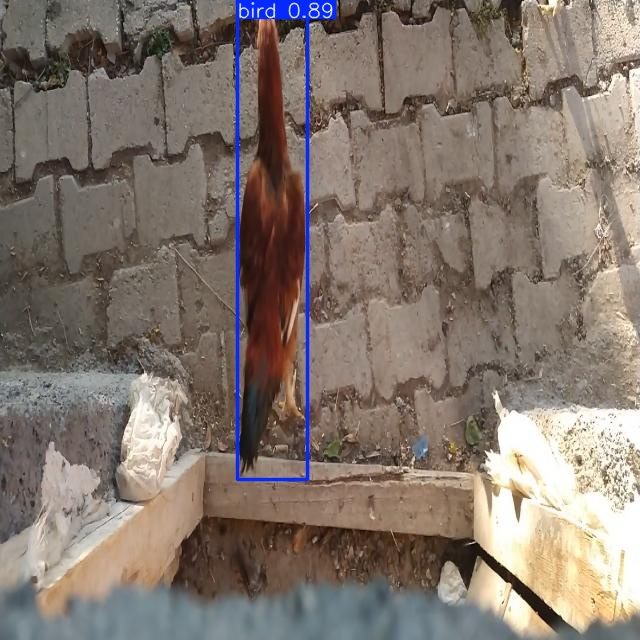

In [ ]:
from IPython.display import Image, display
import os

pred_dir = "runs/detect/predict"
samples = os.listdir(pred_dir)[:5]

for img in samples:
    display(Image(filename=os.path.join(pred_dir, img)))


In [ ]:
#Quantitative Evaluation (mAP, Precision, Recall)
metrics = model.val(data="data.yaml")
print(metrics)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1928.0±470.1 MB/s, size: 101.7 KB)
val: Scanning /content/val/labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 75/75 86.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.8s/it 14.0s
                   all         75        213      0.967      0.973      0.982      0.867
Speed: 6.1ms preprocess, 172.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d45cd1a59d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.00

In [ ]:
#Test on Video (Detection + Tracking)
#Upload your poultry CCTV video
from google.colab import files
files.upload()  # upload poultry_cctv.mp4


In [ ]:
model.track(
    source="poultry_cctv.mp4",
    tracker="bytetrack.yaml",
    conf=0.4,
    persist=True,
    save=True
)


In [ ]:
#Bird Count Over Time (Final Requirement)

#This produces time-based bird count data.
import cv2
from collections import defaultdict

cap = cv2.VideoCapture("poultry_cctv.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)

frame_counts = defaultdict(set)
frame_id = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True, conf=0.4)

    if results[0].boxes.id is not None:
        ids = results[0].boxes.id.cpu().numpy()
        for tid in ids:
            frame_counts[frame_id].add(int(tid))

    frame_id += 1

cap.release()

# Convert to time-based output
bird_count_time_series = [
    {
        "time_sec": round(frame / fps, 2),
        "bird_count": len(ids)
    }
    for frame, ids in frame_counts.items()
]

bird_count_time_series[:10]


In [ ]:
#Save Results as JSON (Submission Ready)
import json

with open("bird_count_over_time.json", "w") as f:
    json.dump(bird_count_time_series, f, indent=4)

print("bird_count_over_time.json saved successfully")
